# Texture-Based Optical Guided Despeckling of SAR Image

In [1]:
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from scripts.texture_descriptor import rgb2gray, rgb2lab
from scripts.despeckle import SARDespeckling

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[cuda(id=0)]


In [2]:
sar_despeckling = SARDespeckling()

### Load data

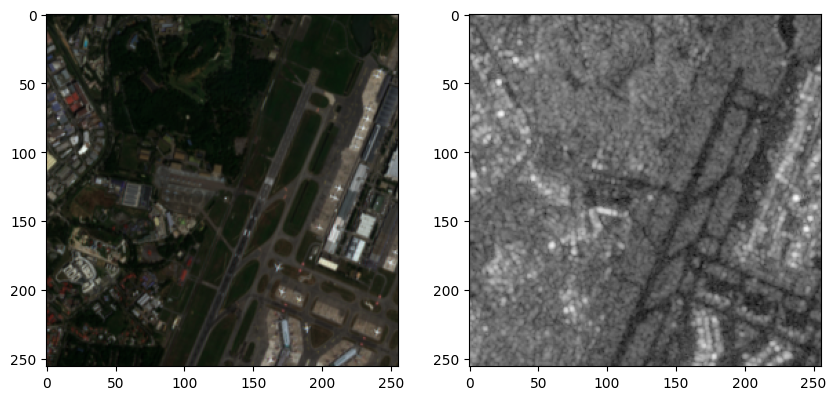

In [3]:
input_path = "../data/data.npz"
data = np.load(input_path)

eo = data['eo']
sar = data['sar']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eo)
plt.subplot(1, 2, 2)
plt.imshow(sar, cmap='gray')

In [7]:
opt_rgb = eo
sar = sar

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape, opt_rgb.shape)

(256, 256, 1) (256, 256, 1) (256, 256, 3) (256, 256, 3)


### Compute texture descriptor

In [8]:
params_texture_descriptor = {
    'opt': opt_lab,
    'radius': 7,
}

S = sar_despeckling._step1_compute_texture_descriptor(**params_texture_descriptor)

INFO:root:Computing texture descriptor...
INFO:root:Texture descriptor computed in 4.43 seconds.


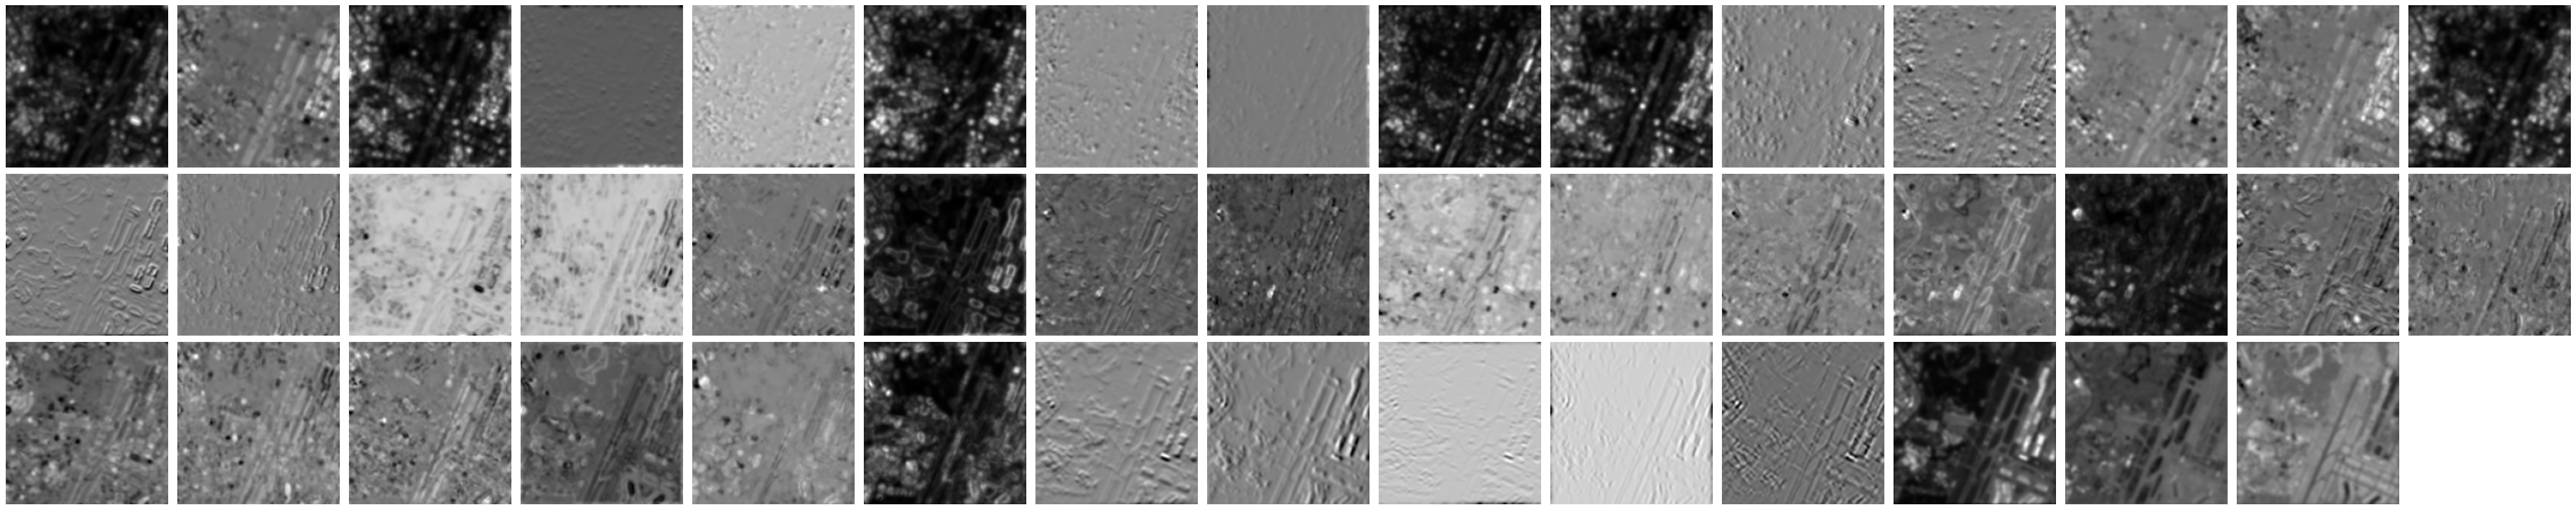

In [9]:
D = S.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

### MUBF

In [11]:
params_mubf = {
    'target': S,
    'guides': [opt_gray, sar],  # (H, W, 1)
    'sigma_spatial': 5,
    'sigma_guides': [0.001, 0.01],
    'gamma_guides': [1.0, 1.0],
    'alpha': 5,
    'n_iterations': 100,
    'n_blocks': 10
}

S_mubf = sar_despeckling._step2_filter_texture_descriptor(**params_mubf)

INFO:root:Filtering texture descriptor with MUBF...
Iterations: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]
INFO:root:Texture descriptor filtering completed in 102.08 seconds.


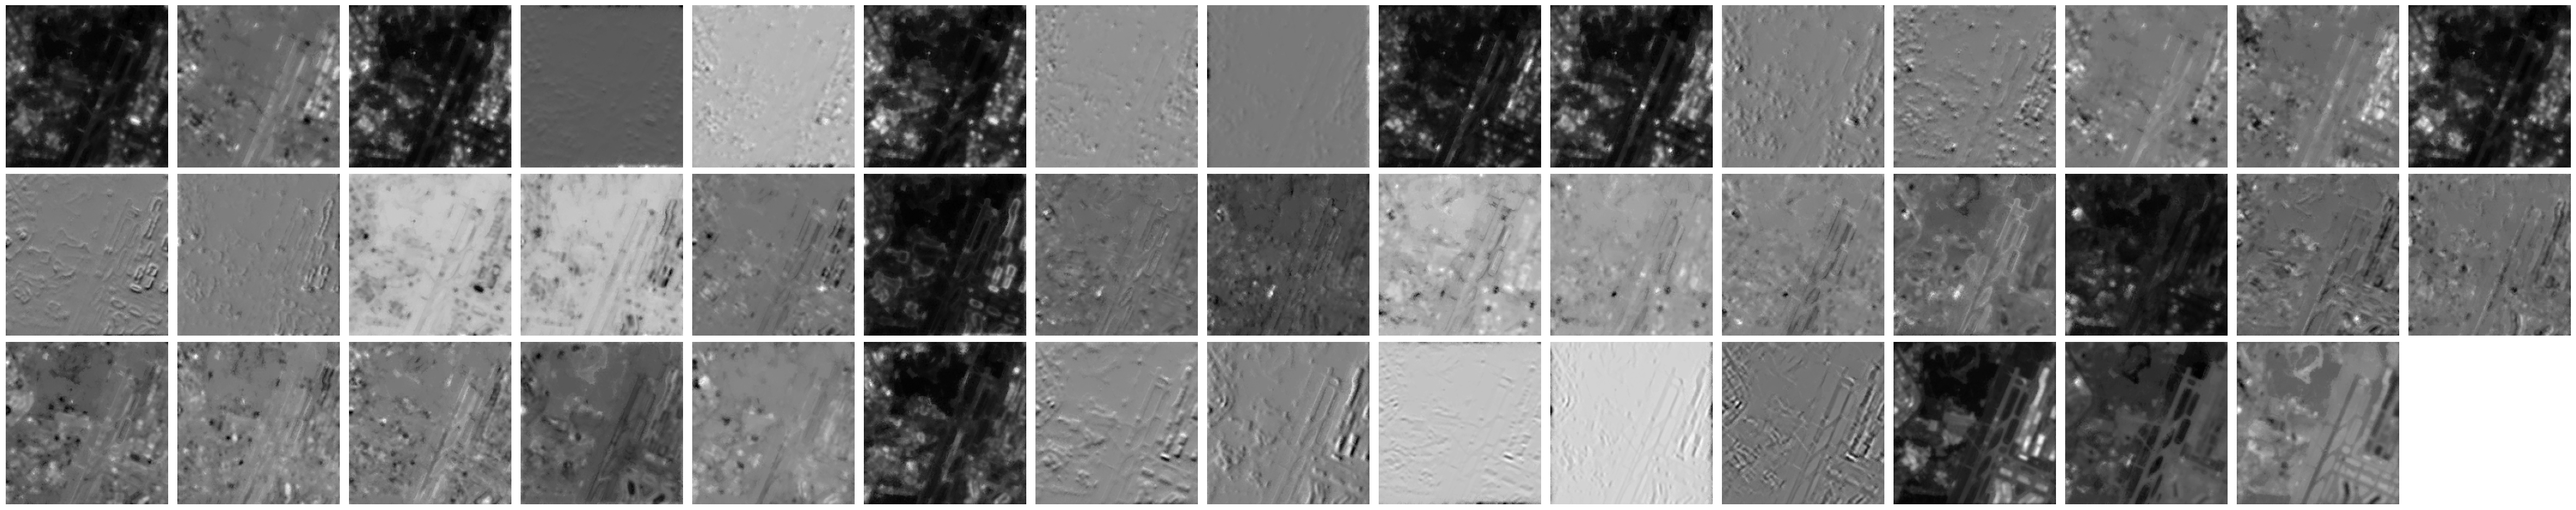

In [12]:
D = S_mubf.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_mubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

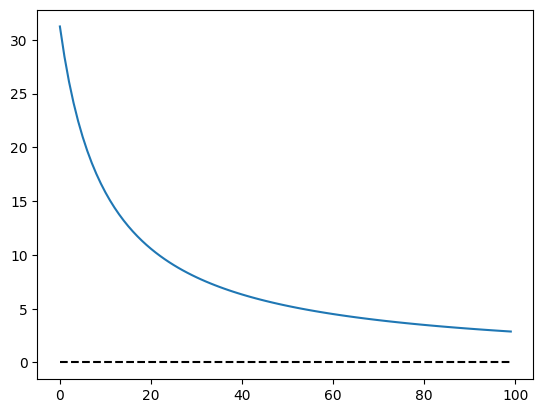

In [13]:
plt.plot(sar_despeckling.error)
plt.plot(np.arange(len(sar_despeckling.error)), np.zeros_like(sar_despeckling.error), 'k--')

### Despeckle

In [14]:
params_despeckling = {
    "sar": sar,
    "descriptor": S_mubf,
    "sigma_distance": 1.5,
    "radius_despeckling": 30,
    "n_blocks": 20
}

sar_filtered = sar_despeckling._step3_despeckle(**params_despeckling)

INFO:root:Despeckling SAR image...
Despeckling: 100%|██████████| 400/400 [00:06<00:00, 59.92block/s] 
INFO:root:Despeckling completed in 6.86 seconds.


In [15]:
params = params_texture_descriptor | params_mubf | params_despeckling
filtered_keys = ['opt', 'target', 'guides', 'n_blocks', 'sar', 'descriptor']
for key in filtered_keys:
    params.pop(key)

params_filtered = params
name = 'tbog'
for key, value in params_filtered.items():
    if isinstance(value, list):
        value = '+'.join([str(v) for v in value])
    name += f"_{key}={value}"

name

'tbog_radius=7_sigma_spatial=5_sigma_guides=0.001+0.01_gamma_guides=1.0+1.0_alpha=5_n_iterations=100_sigma_distance=1.5_radius_despeckling=30'

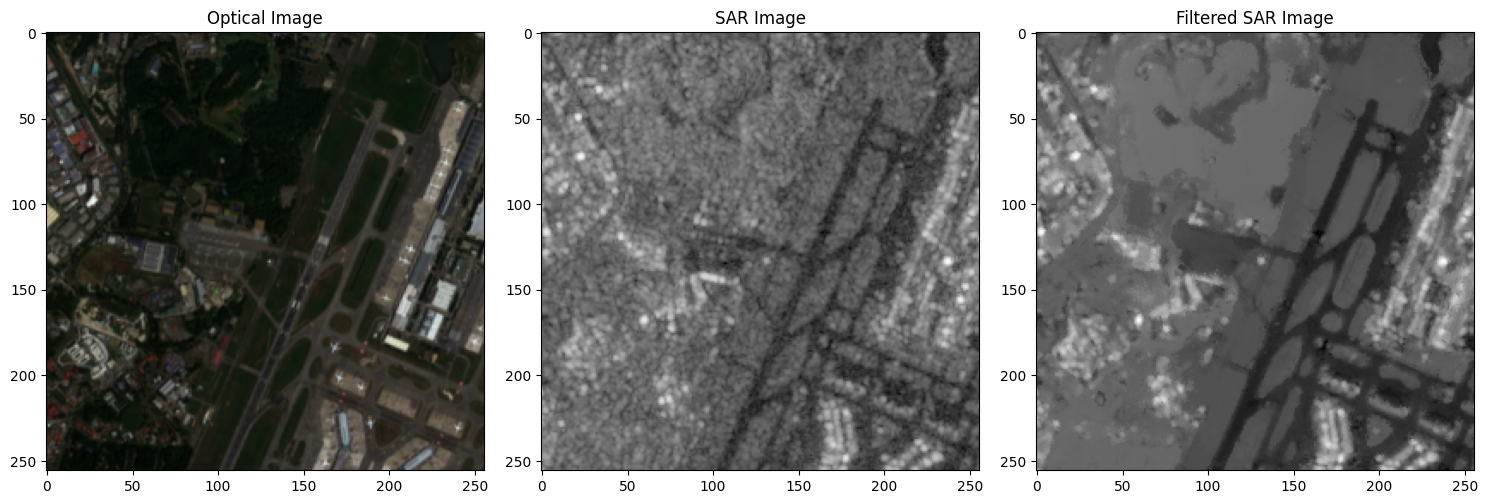

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(opt_rgb)
plt.title('Optical Image')
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.title('Filtered SAR Image')
plt.tight_layout()
plt.savefig(f'/home/nus/Downloads/{name}.png', dpi=300)

In [19]:
import scipy
from scripts.utils import c2ap
from pathlib import Path

def save_image(output_path: str, image: np.ndarray, key: str):
    """Save an image to a file."""
    plt.imsave(output_path.replace('.mat', '.png'), c2ap(image)[0].squeeze(), cmap='gray')  # Preview
    scipy.io.savemat(output_path, {key: image})

In [25]:
# save_image((Path.home() / 'workspace/despeckling/despeckling/results/output.mat').as_posix(), sar_filtered, 'sar_despeckled')
save_image((Path.home() / 'workspace/despeckling/despeckling/baselines/tbog/results/output.mat').as_posix(), sar_filtered, 'sar_despeckled')